<a href="https://colab.research.google.com/github/hublun/Bayesian_Aggregation_Average_Data/blob/master/NumPyro_2024_1_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Using the OpenAI Library to Programmatically Access GPT-3.5-turbo!

This notebook was authored by [DRC Lab](http://www.dulun.com)

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [2]:
!nvidia-smi

Tue Jan 16 15:12:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import jax

In [4]:
jax.devices()

[cuda(id=0)]

In [5]:
from jax import grad
import jax.numpy as jnp

def tanh(x):  # Define a function
  y = jnp.exp(-2.0 * x)
  return (1.0 - y) / (1.0 + y)

grad_tanh = grad(tanh)  # Obtain its gradient function
print(grad_tanh(1.0))   # Evaluate it at x = 1.0

0.4199743




---



In [6]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [7]:
import numpyro

In [8]:
numpyro.set_platform('gpu')

In [9]:
numpyro.set_host_device_count(3)

In [10]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import set_matplotlib_formats

import jax.numpy as jnp
from jax import random

import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive

if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

numpyro.set_host_device_count(4)
assert numpyro.__version__.startswith("0.13.2")



---



Length of time series: 114


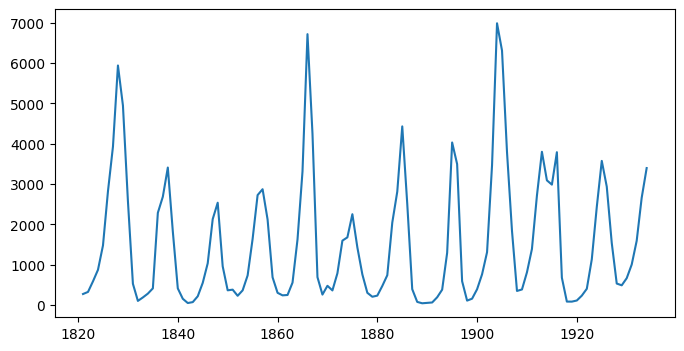

In [11]:
URL = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/lynx.csv"
lynx = pd.read_csv(URL, index_col=0)
data = lynx["value"].values

print("Length of time series:", data.shape[0])
plt.figure(figsize=(8, 4))
plt.plot(lynx["time"], data)
plt.show()

In [12]:
lynx.head()

,time,value
rownames,,
1,1821,269
2,1822,321
3,1823,585
4,1824,871
5,1825,1475


In [13]:
lynx.describe()

,time,value
count,114.000000,114.000000
mean,1877.500000,1538.017544
std,33.052988,1585.843914
min,1821.000000,39.000000
25%,1849.250000,348.250000
50%,1877.500000,771.000000
75%,1905.750000,2566.750000
max,1934.000000,6991.000000


In [14]:
y_train, y_test = jnp.array(data[:80], dtype=jnp.float32), data[80:]



---



The model we are going to use is called **Seasonal, Global Trend**, which when tested on 3003 time series of the [M-3 competition](https://forecasters.org/resources/time-series-data/m3-competition/), has been known to outperform other models originally participating in the competition:

\begin{align}
\text{exp-val}_{t} &= \text{level}_{t-1} + \text{coef-trend} \times \text{level}_{t-1}^{\text{pow-trend}} + \text{s}_t \times \text{level}_{t-1}^{\text{pow-season}}, \\
\sigma_{t} &= \sigma \times \text{exp-val}_{t}^{\text{powx}} + \text{offset}, \\
y_{t} &\sim \text{StudentT}(\nu, \text{exp-val}_{t}, \sigma_{t})
\end{align}

, where `level` and `s` follows the following recursion rules:

\begin{align}
\text{level-p} &=
\begin{cases}
y_t - \text{s}_t \times \text{level}_{t-1}^{\text{pow-season}} & \text{if } t \le \text{seasonality}, \\
\text{Average} \left[y(t - \text{seasonality} + 1), \ldots, y(t)\right] & \text{otherwise},
\end{cases} \\
\text{level}_{t} &= \text{level-sm} \times \text{level-p} + (1 - \text{level-sm}) \times \text{level}_{t-1}, \\
\text{s}_{t + \text{seasonality}} &= \text{s-sm} \times \frac{y_{t} - \text{level}_{t}}{\text{level}_{t-1}^{\text{pow-trend}}}
+ (1 - \text{s-sm}) \times \text{s}_{t}.
\end{align}

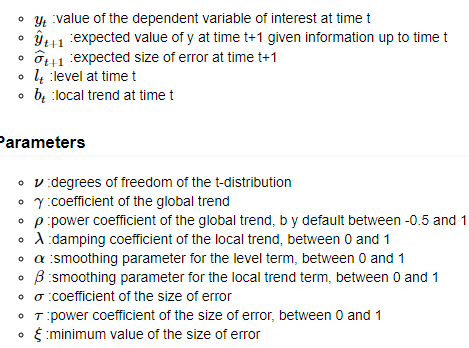



---



In [15]:
def sgt(y, seasonality, future=0):
    # heuristically, standard derivation of Cauchy prior depends on
    # the max value of data
    cauchy_sd = jnp.max(y) / 150

    # NB: priors' parameters are taken from
    # https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R
    nu = numpyro.sample("nu", dist.Uniform(2, 20))
    powx = numpyro.sample("powx", dist.Uniform(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(cauchy_sd))
    offset_sigma = numpyro.sample(
        "offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10, scale=cauchy_sd)
    )

    coef_trend = numpyro.sample("coef_trend", dist.Cauchy(0, cauchy_sd))
    pow_trend_beta = numpyro.sample("pow_trend_beta", dist.Beta(1, 1))
    # pow_trend takes values from -0.5 to 1
    pow_trend = 1.5 * pow_trend_beta - 0.5
    pow_season = numpyro.sample("pow_season", dist.Beta(1, 1))

    level_sm = numpyro.sample("level_sm", dist.Beta(1, 2))
    s_sm = numpyro.sample("s_sm", dist.Uniform(0, 1))

    init_s = numpyro.sample("init_s", dist.Cauchy(0, y[:seasonality] * 0.3))

    def transition_fn(carry, t):
        level, s, moving_sum = carry
        season = s[0] * level**pow_season
        exp_val = level + coef_trend * level**pow_trend + season
        exp_val = jnp.clip(exp_val, a_min=0)
        # use expected vale when forecasting
        y_t = jnp.where(t >= N, exp_val, y[t])

        moving_sum = (
            moving_sum + y[t] - jnp.where(t >= seasonality, y[t - seasonality], 0.0)
        )
        level_p = jnp.where(t >= seasonality, moving_sum / seasonality, y_t - season)
        level = level_sm * level_p + (1 - level_sm) * level
        level = jnp.clip(level, a_min=0)

        new_s = (s_sm * (y_t - level) / season + (1 - s_sm)) * s[0]
        # repeat s when forecasting
        new_s = jnp.where(t >= N, s[0], new_s)
        s = jnp.concatenate([s[1:], new_s[None]], axis=0)

        omega = sigma * exp_val**powx + offset_sigma
        y_ = numpyro.sample("y", dist.StudentT(nu, exp_val, omega))

        return (level, s, moving_sum), y_

    N = y.shape[0]
    level_init = y[0]
    s_init = jnp.concatenate([init_s[1:], init_s[:1]], axis=0)
    moving_sum = level_init

    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, (level_init, s_init, moving_sum), jnp.arange(1, N + future)
        )
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])

Note that `level` and `s` are updated recursively while we collect the expected value at each time step. NumPyro uses [JAX](https://github.com/google/jax) in the backend to JIT compile many critical parts of the NUTS algorithm, including the verlet integrator and the tree building process. However, doing so using Python's `for` loop in the model will result in a long compilation time for the model, so we use `scan` - which is a wrapper of [lax.scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html#jax.lax.scan) with supports for NumPyro primitives and handlers. A detailed explanation for using this utility can be found in [NumPyro documentation](http://num.pyro.ai/en/latest/primitives.html#scan). Here we use it to collect `y` values while the triple `(level, s, moving_sum)` plays the role of carrying state.

Another note is that instead of declaring the observation site `y` in `transition_fn`

```python
numpyro.sample("y", dist.StudentT(nu, exp_val, omega), obs=y[t])
```

, we have used [condition](http://num.pyro.ai/en/stable/handlers.html#numpyro.handlers.condition) handler here. The reason is we also want to use this model for forecasting. In forecasting, future values of `y` are non-observable, so `obs=y[t]` does not make sense when `t >= len(y)` (caution: index out-of-bound errors do not get raised in JAX, e.g. `jnp.arange(3)[10] == 2`). Using `condition`, when the length of `scan` is larger than the length of the conditioned/observed site, unobserved values will be sampled from the distribution of that site.

In [16]:
# scan(f, init, xs, length=None, reverse=False, history=1)[source]¶
# This primitive scans a function over the leading array axes of xs
# while carrying along state. See jax.lax.scan() for more information.

#Usage:

import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan

def gaussian_hmm(y=None, T=10):
    def transition(x_prev, y_curr):
        x_curr = numpyro.sample('x', dist.Normal(x_prev, 1))
        y_curr = numpyro.sample('y', dist.Normal(x_curr, 1), obs=y_curr)
        return x_curr, (x_curr, y_curr)

    x0 = numpyro.sample('x_0', dist.Normal(0, 1))
    _, (x, y) = scan(transition, x0, y, length=T)
    return (x, y)

# here we do some quick tests
with numpyro.handlers.seed(rng_seed=0):
    x, y = gaussian_hmm(np.arange(10.))
assert x.shape == (10,) and y.shape == (10,)
assert np.all(y == np.arange(10))

with numpyro.handlers.seed(rng_seed=0):  # generative
    x, y = gaussian_hmm()
assert x.shape == (10,) and y.shape == (10,)

In [17]:
print("Lag values sorted according to their autocorrelation values:\n")
print(jnp.argsort(autocorrelation(y_train))[::-1])

Lag values sorted according to their autocorrelation values:

[ 0 67 57 38 68  1 29 58 37 56 28 10 19 39 66 78 47 77  9 79 48 76 30 18
 20 11 46 59 69 27 55 36  2  8 40 49 17 21 75 12 65 45 31 26  7 54 35 41
 50  3 22 60 70 16 44 13  6 25 74 53 42 32 23 43 51  4 15 14 34 24  5 52
 73 64 33 71 72 61 63 62]


In [18]:
%%time
kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=1)
mcmc.run(random.PRNGKey(0), y_train, seasonality=38)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [15:46<00:00,  2.11it/s, 127 steps of size 3.06e-02. acc. prob=0.82]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     19.25     74.77      0.81    -56.43    134.21     79.05      1.01
       init_s[0]     13.09    189.97     29.13   -250.04    274.20     24.47      1.24
       init_s[1]    -32.54     71.17    -35.78   -144.49     80.96     83.48      1.02
       init_s[2]     31.41    137.12     17.17   -219.75    251.94     14.48      1.00
       init_s[3]    103.36    217.39     91.24   -267.88    511.39     11.86      1.01
       init_s[4]    282.23    346.44    289.37   -346.42    790.45      6.76      1.39
       init_s[5]    960.15    579.35    979.78    -48.04   1786.38      8.34      1.25
       init_s[6]   1732.19    841.24   1689.82    391.64   3046.16      7.29      1.25
       init_s[7]   3725.76   1252.97   3620.58   1881.02   5780.47     14.12      1.01
       init_s[8]   2331.36    913.78   2189.04    833.86   3703.12     24.59      1.27
       init_s[9]    659.17    738.33    70

In [19]:
predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
forecast_marginal = predictive(random.PRNGKey(1), y_train, seasonality=38, future=34)[
    "y_forecast"
]

In [20]:
y_pred = jnp.mean(forecast_marginal, axis=0)
sMAPE = jnp.mean(jnp.abs(y_pred - y_test) / (y_pred + y_test)) * 200
msqrt = jnp.sqrt(jnp.mean((y_pred - y_test) ** 2))
print("sMAPE: {:.2f}, rmse: {:.2f}".format(sMAPE, msqrt))

sMAPE: 78.49, rmse: 1427.03


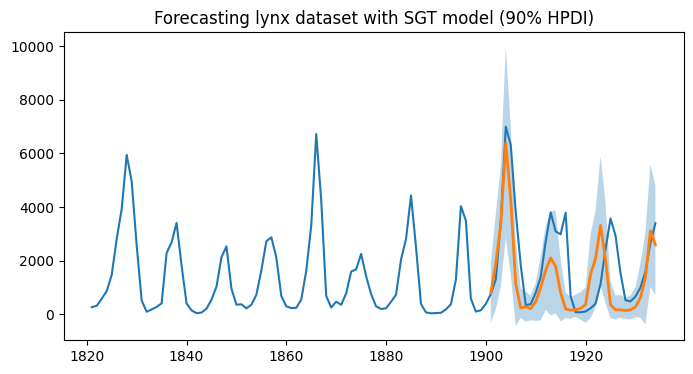

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(lynx["time"], data)
t_future = lynx["time"][80:]
hpd_low, hpd_high = hpdi(forecast_marginal)
plt.plot(t_future, y_pred, lw=2)
plt.fill_between(t_future, hpd_low, hpd_high, alpha=0.3)
plt.title("Forecasting lynx dataset with SGT model (90% HPDI)")
plt.show()